<a href="https://colab.research.google.com/github/Jayavathsan/DeepLearning/blob/main/PyTorch/StyleTransfer/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Style transfer


In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

# Import VGG19 and freeze all layers

In [4]:
# import the model
vggNet = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for parameter in vggNet.parameters():
    parameter.requires_grad = False

# set to evaluation mode
vggNet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 65.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vggNet.to(device);

# Import two images

In [21]:
contentImage = imread('https://images.freeimages.com/images/large-previews/1a0/sydney-opera-house-1476036.jpg')
styleImage   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
targetImage = np.random.randint(low=0,high=255,size=contentImage.shape,dtype=np.uint8)

print(contentImage.shape)
print(targetImage.shape)
print(styleImage.shape)

<ipython-input-21-a8fcd01d00ce>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  contentImage = imread('https://images.freeimages.com/images/large-previews/1a0/sydney-opera-house-1476036.jpg')
<ipython-input-21-a8fcd01d00ce>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  styleImage   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')


(960, 1280, 3)
(960, 1280, 3)
(4000, 3223, 3)


In [22]:
# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
contentImage = Ts( contentImage ).unsqueeze(0).to(device)
styleImage   = Ts( styleImage   ).unsqueeze(0).to(device)
targetImage  = Ts( targetImage  ).unsqueeze(0).to(device)

print(contentImage.shape)
print(targetImage.shape)
print(styleImage.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 341])
torch.Size([1, 3, 256, 341])
torch.Size([1, 3, 317, 256])


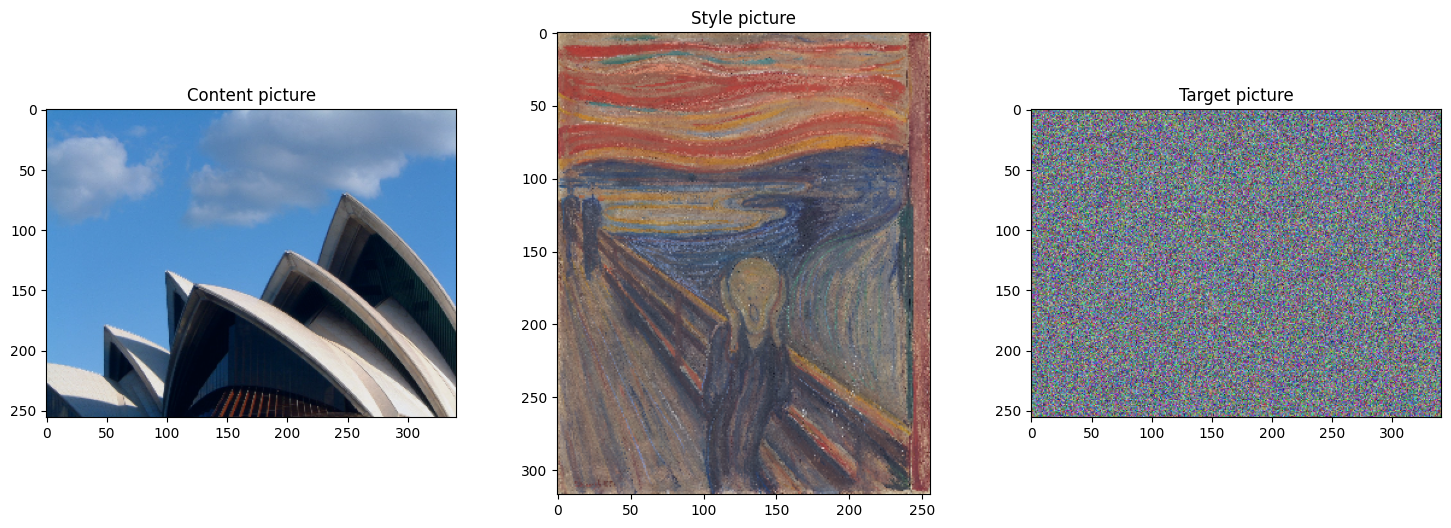

In [23]:
# Images
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = contentImage.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = styleImage.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Style picture')

pic = targetImage.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Target picture')



plt.show()

# Functions to extract image feature map activations

In [24]:
# A function that returns feature maps

def getFeatureMapActivations(img,net):

  # initialize feature maps as a list
  featureMaps = []
  featureNames = []

  convLayerIndex = 0

  # loop through all layers in the "features" block
  for layerNumber in range(len(net.features)):

    # print out info from this layer
    # print(layerNumber,net.features[layerNumber])

    # process the image through this layer
    img = net.features[layerNumber](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layerNumber]):
      featureMaps.append( img )
      featureNames.append( 'ConvLayer_' + str(convLayerIndex) )
      convLayerIndex += 1

  return featureMaps,featureNames

In [25]:
# A function that returns the Gram matrix of the feature activation map

def gramMatrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [26]:
# inspect the output of the function
featureMaps,featureNames = getFeatureMapActivations(contentImage,vggNet)

# print out some info
for i in range(len(featureNames)):
  print('Feature map "%s" is size %s'%(featureNames[i],(featureMaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 341])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 341])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 170])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 170])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 85])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 85])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 85])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 85])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_15" is size torch.Siz

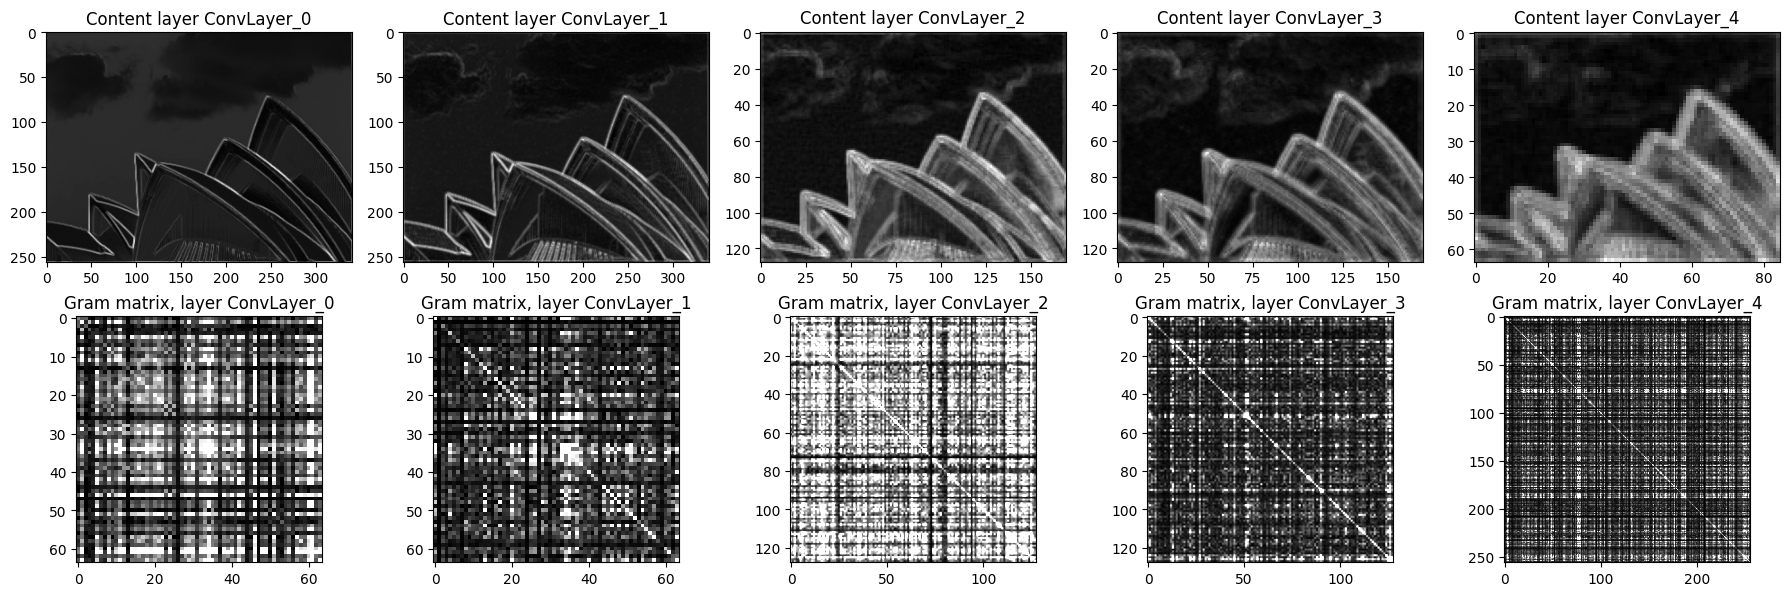

In [27]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActivations(contentImage,vggNet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gramMatrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

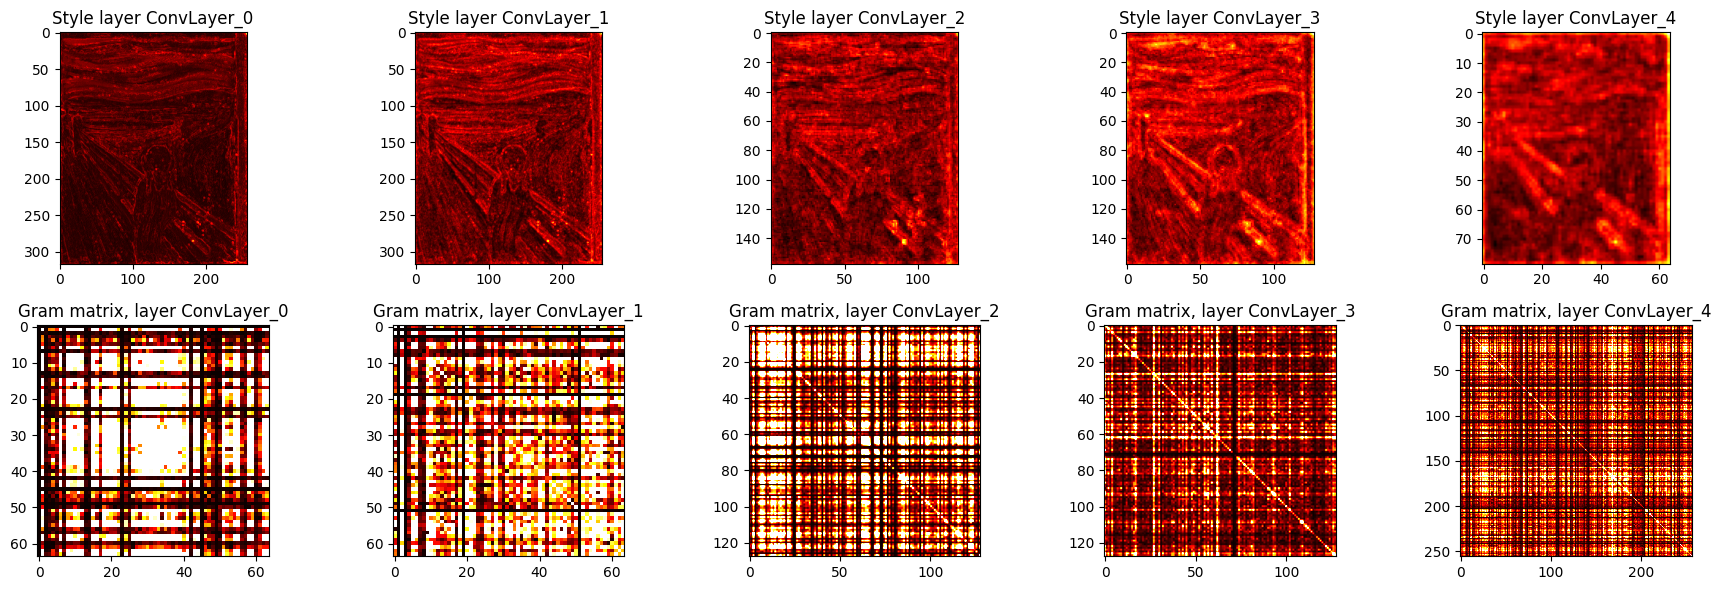

In [28]:
# For the style
styleFeatureMaps,styleFeatureNames = getFeatureMapActivations(styleImage,vggNet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gramMatrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

# Now for the transfer

In [38]:
# layers to use
contentLayers = [ 'ConvLayer_1','ConvLayer_4' ]
styleLayers   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
styleWeights  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

In [41]:
# make a copy of the target image and push to GPU
target = targetImage.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e5

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActivations(target,vggNet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layer in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layer] in contentLayers:
      contentLoss += torch.mean( (targetFeatureMaps[layer]-contentFeatureMaps[layer])**2 )


    # compute the style loss
    if targetFeatureNames[layer] in styleLayers:

      # Gram matrices
      targetGram = gramMatrix(targetFeatureMaps[layer])
      styleGram  = gramMatrix(styleFeatureMaps[layer])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (targetGram-styleGram)**2 ) * styleWeights[styleLayers.index(targetFeatureNames[layer])]


  # combined loss
  combinedLoss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combinedLoss.backward()
  optimizer.step()


# Images after transfer

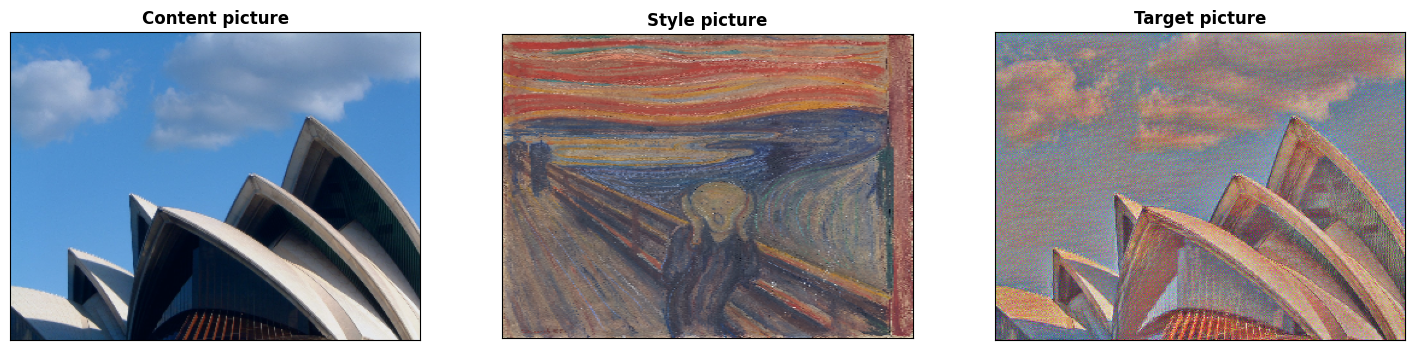

In [42]:
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = contentImage.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = styleImage.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic,aspect=.6)
ax[1].set_title('Style picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[2].imshow(pic)
ax[2].set_title('Target picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.show()